In [1]:
"""
   This section of the code simply sets up all possible variables we might want to change during training.
"""
import os, sys, random, gzip, optparse
import numpy as np                     # Math and Deep Learning libraries
import torch                
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm                  # Pretty status bars
from collections import defaultdict
np.seterr(divide='ignore')             # Ignore divide by zero errors
np.warnings.filterwarnings('ignore')

# Use a GPU when possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

parser = optparse.OptionParser(description='FIND')
parser.add_option('--name',       type=str,            default='')
parser.add_option('--batch-size', type=int,            default=32,    help='batch size')
parser.add_option('--epochs',     type=int,            default=100,   help='number of epochs')
parser.add_option('--hidden-dim', type=int,            default=256,   help='hidden dim')
parser.add_option('--log',        type=str,            default='./logs/')
parser.add_option('--load',       type=str,            default='',    help='Load model')
parser.add_option('--load_test',  type=str,            default='',    help='Load specific test file')
parser.add_option('--binary',     type=str,            default='',    help='Binary classifer based on argument')
parser.add_option('--lr',         type=float,          default=5e-3)
parser.add_option('--nitro',      action='store_true', default=False, help='Train/Test on nitrogenase')
parser.add_option('--bd',         action='store_true', default=False, help='Train/Test on cytochrome bd oxidase')
parser.add_option('--test',       action='store_true', default=False, help='Swap validation for test set')
parser.add_option('--confusion',  action='store_true', default=False, help='If test, generate confusion matrix')
parser.add_option('--pconfusion', action='store_true', default=False, help='sum probabilities for confusion')
parser.add_option('--reweight',   action='store_true', default=False)


sys.argv = sys.argv[3:]  # Remove pykernel launcher
args, _ = parser.parse_args()

# BD is small with highly varying lengths so we shrink batch and therefore learning rate
# Example run below
args.bd = True
args.batch_size = 4
args.lr = 1e-3

In [2]:
###############################################################################
##    Infrastructure to process Data into Numpy Arrays of Integers
##    Here we specify the dataset (indicated by args.nitro, args.bd or default HCO)
##    Then we convert letters to numbers via the acids dictionary.
##    We also compute the set of function labels (optionally training with binary)
###############################################################################
DATA_DIR = "data/"
acids = {' ':0, 'A':1, 'C':2, 'E':3, 'D':4, 'G':5, 'F':6, 'I':7, 'H':8, \
         'K':9, 'M':10, 'L':11, 'N':12, 'Q':13, 'P':14, 'S':15, 'R':16, \
         'T':17, 'W':18, 'V':19, 'Y':20, 'X':21 }
ints = {}
for v in acids:
    ints[acids[v]] = v

lbls = {}
ilbls = {}

if args.nitro:
    labels_file = "nitro.labels.txt"
elif args.bd:
    labels_file = "bd.labels.txt"
else:
    labels_file = "hco.labels.txt"

L = [line.strip() for line in open(DATA_DIR + labels_file,'r')]
# For logging we will store details of our training regime in the file name
run = "binary" if args.binary else "multi"
run += ".e{}".format(args.epochs)
run += ".h{}".format(args.hidden_dim)
run += ".b{}".format(args.batch_size)
if args.reweight:
    run += ".reweight"

if len(args.binary) == 0:
    for v in L:
        lbls[v] = len(lbls)
        ilbls[lbls[v]] = v
    num_labels = len(lbls)
else:
    for v in L:
        if v == args.binary:
            lbls[v] = 1
            ilbls[lbls[v]] = v
        else:
            lbls[v] = 0
            ilbls[lbls[v]] = "OTHER"
    print(lbls, ilbls)
    num_labels = 2
    run += "." + args.binary

In [3]:
###############################################################################
##    This block introduces helper functions
##    to_int and to_string convert AAs back and forth between representations
##    sort_data and pad_data help create batches of data of a fixed length to pass
##      to the network.
###############################################################################

def to_int(seq):
    """   Map AA sequence to integers  """
    seq = seq.replace("*","")
    conv = []
    for i in range(len(seq)):
        if seq[i] not in acids:
            print(i, seq)
        conv.append(acids[seq[i]])
    return np.array(conv)

def to_string(seq):
    """  Map ints to AA sequence  """
    return "".join([ints[s] for s in seq])

def sort_data(inputs, outputs, strs=[]):
    """ 
      Sorted by input length and then output length
    """
    ignore_strs = False
    if len(strs) == 0:
        ignore_strs = True
        strs = [""]*len(inputs)
    v = []
    for i, o, s in zip(inputs, outputs, strs):
        v.append((len(i), i, o, s))
    v.sort(key=lambda x: x[0])

    sorted_inputs = []
    sorted_outputs = []
    sorted_strs= []
    for len_i, i, o, s in v:
        sorted_inputs.append(i)
        sorted_outputs.append(o)
        sorted_strs.append(s)

    if ignore_strs:
        return sorted_inputs, sorted_outputs
    else:
        return sorted_inputs, sorted_outputs, sorted_strs

def pad_data(inputs):
    max_i = max([len(i) for i in inputs])
  
    padded_i = np.zeros((len(inputs), max_i), dtype=np.int64)
    for i in range(len(inputs)):
        padded_i[i, :len(inputs[i])] = np.copy(inputs[i])

    return padded_i

In [4]:
###############################################################################
##    Data is loaded, Train/Validation/Test, counted, converted to numbers and 
##    stored in numpy arrays.
###############################################################################
""" Data & Parameters """
if args.nitro:
    prefix = "nitro.labeled" 
elif args.bd:
    prefix = "bd.labeled"
else:
    prefix = "hco.labeled"

data = [line.strip().split() for line in open(DATA_DIR + prefix + ".train",'r')]
if args.test:
    val = [line.strip().split() for line in open(DATA_DIR + prefix + ".test",'r')]
elif args.load_test != '':
    val = [line.strip().split() for line in open(args.load_test,'r')]
else:
    val = [line.strip().split() for line in open(DATA_DIR + prefix + ".val",'r')]

for vals in data:
    if len(vals) != 2:
        print(vals)
strs = np.array([sequence for label, sequence in data])
inputs = [to_int(sequence) for label, sequence in data]
outputs = np.array([lbls[label] for label, sequence in data])

print("Training counts\t")
l_c = defaultdict(int) 
for v in outputs:
    l_c[ilbls[v]] += 1
V = [(l_c[v],v) for v in l_c]
V.sort()
V.reverse()
print("    ".join(["{}: {}".format(lbl, cnt) for cnt,lbl in V]))

count = np.zeros(len(ilbls), dtype=np.float32)

for v in range(len(ilbls)):
    if ilbls[v] in l_c:
        count[v] += l_c[ilbls[v]]
distr = np.sum(count)/(np.size(count)*count) #1. - count/np.sum(count)
weight = torch.from_numpy(100*distr).to(device)

inps, outs, strs = sort_data(inputs, outputs, strs)
outs = np.array(outs)
strs = np.array(strs)

t_strs = np.array([sequence for label, sequence in val])
t_inps = [to_int(sequence) for label, sequence in val]
t_outs = np.array([lbls[label] for label, sequence in val])
t_inps, t_outs, t_strs = sort_data(t_inps, t_outs, t_strs)
t_outs = np.array(t_outs)
t_strs = np.array(t_strs)

print("Train Inps: ", len(inputs))
print("Train Outs: ", outputs.shape)
print("Test  Inps: ", len(t_inps))
print("Test  Outs: ", t_outs.shape)
print("Labels\t",lbls)

Training counts	
E1: 381    C: 196    E2: 191    A: 50    E4: 40    E3: 30    B: 29
Train Inps:  917
Train Outs:  (917,)
Test  Inps:  126
Test  Outs:  (126,)
Labels	 {'E4': 0, 'C': 1, 'E1': 2, 'A': 3, 'E2': 4, 'B': 5, 'E3': 6}


In [5]:
###############################################################################
##    Model definition + Helper Functions
###############################################################################
class Net(nn.Module):
    def __init__(self, width=3, RF=19):
        """
           Build a stack of 1D convolutions with batch norm and ReLU activations
           The final two convolutions are simply linear layers, then followed by
           a prediction and attention layer.
        """
        super(Net, self).__init__()
        self.width = width
        self.RF = RF
    
        self.embedding = nn.Embedding(len(acids), args.hidden_dim)
        layers = [
          nn.Conv1d(args.hidden_dim, args.hidden_dim, self.width),
          nn.ReLU(),
          nn.BatchNorm1d(args.hidden_dim),
          nn.Conv1d(args.hidden_dim, args.hidden_dim, self.width*2),
          nn.ReLU(),
          nn.BatchNorm1d(args.hidden_dim),
          nn.Conv1d(args.hidden_dim, args.hidden_dim, self.width*4),
          nn.ReLU(),
          nn.BatchNorm1d(args.hidden_dim),
          nn.Conv1d(args.hidden_dim, args.hidden_dim, 1),
          nn.ReLU(),
          nn.Conv1d(args.hidden_dim, args.hidden_dim, 1),
          nn.ReLU(),
        ]

        self.conv_stack = nn.Sequential(*layers)
    
        self.pred = nn.Conv1d(args.hidden_dim, num_labels, 1)
        self.att = nn.Conv1d(args.hidden_dim, 1, 1)

    def forward(self, x):
        embed = self.embedding(x).permute(0,2,1)
        embed = self.conv_stack(embed)

        # Log probabilities for every class at every substring
        logits = self.pred(embed)
    
        # Un-normalized weight of a given n-gram
        att = self.att(embed)
        # Reshape [b,L] --> [b,1,L]  -- and normalize
        re_att = F.softmax(att.view(x.size()[0],1,-1), dim=-1)
        # Rescale logits by attention weight
        joint = re_att * logits
        # Class distribution
        collapsed = torch.sum(joint, 2)
        return collapsed, att, logits

    def reset_counts(self, epoch):
        self.gold_counts = np.zeros(num_labels)
        self.pred_counts = np.zeros(num_labels)
        self.corr_counts = np.zeros(num_labels)
        self.epoch = epoch

    """ Helper Functions """
    def run_evaluation(self, v_inputs, v_outputs, aggregate=False, verbose=False, showTrain=True):
        net.train(mode=False)
        """
          Run evaluation
        """
        val_loss = 0.0
        val_acc = []
        gold_counts = np.zeros(num_labels)
        pred_counts = np.zeros(num_labels)
        corr_counts = np.zeros(num_labels)

        if args.confusion:
            pairs = np.zeros((num_labels, num_labels))

        v_inps, v_outs = sort_data(v_inputs, v_outputs)
        v_outs = np.array(v_outs)
        batches = []
        indices = list(range(len(v_inps)))
        for start in range(0, len(indices), args.batch_size):
            batches.append((start, min(args.batch_size, len(indices)-start)))

        for start, b_size in tqdm(batches, ncols=80):
            vals = indices[start : start + b_size]
      
            inputs = torch.from_numpy(pad_data(v_inps[indices[start]:indices[start+b_size-1]+1])).to(device)
            labels = torch.from_numpy(v_outs[vals]).to(device)
            logits, att, full = net(inputs)
            att = F.softmax(torch.squeeze(att), dim=-1)
            val_loss += F.cross_entropy(logits, labels).item()
            _, preds = torch.max(logits, 1)
      
            preds = preds.data.cpu().numpy()
            val_acc.extend(list((preds == v_outs[vals])))
      
            np.add.at(pred_counts, preds, 1)
            np.add.at(gold_counts, v_outs[vals], 1)
            np.add.at(corr_counts, preds[(preds == v_outs[vals])], 1)

            if args.confusion:
                if not args.pconfusion:
                    np.add.at(pairs, [v_outs[vals], preds], 1)
                else:
                    dists = F.softmax(logits, -1)
                    for i in range(len(vals)):
                        gold = v_outs[vals][i]

                        tmp = [(dists[i,j], j) for j in range(len(ilbls))]
                        tmp.sort()
                        prob, second = tmp[-2]
                        pairs[gold, second] += 1

            if aggregate:
                self.aggregate_predictors(t_strs[vals], v_outs[vals], full, att)

        if verbose:
            if aggregate or not showTrain:
                self.print_eval((gold_counts, pred_counts, corr_counts))
            else:
                self.print_eval((self.gold_counts, self.pred_counts, self.corr_counts), 
                               (gold_counts, pred_counts, corr_counts))

        if args.confusion:
            out = open("confusion.csv", 'w')
            out.write("," + ",".join([ilbls[i] for i in range(len(ilbls))]) + "\n")
            for i in range(len(ilbls)):
                out.write("{},".format(ilbls[i]))
                for j in range(len(ilbls)):
                    out.write("{},".format(pairs[i,j]))
                out.write("\n")
            out.close()
        return val_loss, 100*np.array(val_acc).mean()

    def aggregate_predictors(self, seqs, outs, full, att):
        dists = F.softmax(full.permute(0, 2, 1), dim=-1)
        if dists.shape[0] == 1:
            att = att.unsqueeze(0)  # batch size of 1 needs to be unsqueezed
        vals = dists * att.unsqueeze(2)
        for b in range(len(seqs)):
            max_val = -1e10
            max_predictor = "NONE"
            max_class = -1
            for i in range(len(att[0])):
                predictor = seqs[b][i:i + self.RF]

                for c in range(num_labels):
                    self.predictors[(predictor, c)] += vals[b,i,c].item() 

                cval, c = torch.max(vals[b,i,:], 0)
                cval = cval.item()
                if cval > max_val:
                    max_val = cval
                    max_predictor = predictor
                    max_class = c.item()
            self.top_predictor.append((max_val, max_predictor, ilbls[max_class], ilbls[outs[b]], seqs[b].strip()))


    def print_predictors(self, epoch):
        start = "nitro" if args.nitro else "bd" if args.bd else "hco"
        rtype = "binary" if args.binary else "multi"
        rewht = "reweight" if args.reweight else "orig"
        fname = "{}.{}.{}.{}.{}.h{}.b{}".format(start, epoch, self.RF, rtype, rewht, args.hidden_dim, args.batch_size)
        
        g = gzip.open("{}.predictors.joint.gz".format(fname),'wt')
        joint = defaultdict(list)
        for seq, lbl in self.predictors:
            joint[ilbls[lbl]].append((self.predictors[(seq, lbl)], seq))
    
        for lbl in joint:
            vals = joint[lbl]
            vals.sort()
            vals.reverse()
            for val, seq in vals:
                g.write("{:5} {:30} {}\n".format(lbl, seq, val))
            g.write("\n")
        g.close()
   

        g = gzip.open("{}.top_predictors.txt.gz".format(fname), 'wt')
        g.write("{:10} {:30} {:5} {:5} {}\n".format("Val", "Predictor", "Pred", "Gold", "Seq"))
        self.top_predictor.sort()
        self.top_predictor.reverse()
        for val, predictor, pred, gold, seq in self.top_predictor:
            g.write("{:10.9f} {:30} {:5} {:5} {}\n".format(val, predictor, pred, gold, seq))
        g.close()


    def print_eval(self, train, test=None): 
        """  Print training performance  """
        gold, pred, corr = train
        p, r = corr / pred, corr / gold
        f = 2*p*r/(p+r)
    
        if test is not None:
            t_gold, t_pred, t_corr = test
            t_p, t_r = t_corr / t_pred, t_corr / t_gold
            t_f = 2*t_p*t_r/(t_p+t_r)
    
        gold_counts = [(gold[lab],lab) for lab in range(num_labels)]
        gold_counts.sort(reverse=True)
        for count, i in gold_counts:
            train_str = "{:<10} {:<5} {:5.3f} {:5.3f} {:5.3f}   ".format(ilbls[i], int(count), p[i], r[i], f[i])
            if test is not None:
                test_str = "{:<5} {:5.3f} {:5.3f} {:5.3f}".format(int(t_gold[i]), t_p[i], t_r[i], t_f[i])
            else:
                test_str = ""
            print(train_str + test_str)

In [6]:
###############################################################################
##    Training Loop
###############################################################################
#torch.cuda.manual_seed(20180119)  <-- set a value for consistency
if args.load != '':
    net = torch.load(args.load)                             # Load Saved Model
    net.to(device)
    if args.confusion:
        loss, acc = net.run_evaluation(t_inps, t_outs, aggregate=args.load_test != '')
    else:
        loss, acc = net.run_evaluation(t_inps, t_outs, aggregate=args.load_test != '')
    print("Acc: {:5.3f}".format(acc))
    if args.load_test != '':
        net.print_predictors("test")
    sys.exit()
else:
    net = Net()
    net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)

"""
  Perform training
"""
prev_acc = 0
for epoch in range(0, args.epochs + 1):
    net.predictors = defaultdict(int)
    net.top_predictor = []

    batches = []
    indices = list(range(len(inps)))
    for start in range(0, len(indices), args.batch_size):
        batches.append((start, min(args.batch_size, len(indices)-start)))
    random.shuffle(batches)

    total_loss = 0.0
    train_acc = []
  
    net.reset_counts(epoch)
    for start, b_size in tqdm(batches, ncols=80):
        r = indices[start : start + b_size]
        
        # Setup
        optimizer.zero_grad()
        inputs = torch.from_numpy(pad_data(inps[indices[start] : indices[start+b_size-1] + 1])).to(device)
        labels = torch.from_numpy(outs[r]).to(device)

        # Predict
        net.train(mode=True)
        logits, att, full = net(inputs)
        if args.reweight:
            ce_loss = F.cross_entropy(logits, labels, weight=weight)
        else:
            ce_loss = F.cross_entropy(logits, labels)
        att = F.softmax(torch.squeeze(att), dim=-1)
    
        # Compute loss and update
        loss = ce_loss
        total_loss += ce_loss.item()
        loss.backward()
        optimizer.step()
    
        # Look at predictions
        _, preds = torch.max(logits, 1)
        dists = full.permute(0,2,1).cpu().data.numpy()
    
        preds = preds.data.cpu().numpy()
        np.add.at(net.pred_counts, preds, 1)
        np.add.at(net.gold_counts, outs[r], 1)
        np.add.at(net.corr_counts, preds[preds == outs[r]], 1)

        train_acc.extend(list(preds == outs[r]))
  
    # Evaluate on validation (during training)
    val_loss, val_acc = net.run_evaluation(t_inps, t_outs, verbose=(epoch % 10 == 0 or epoch == args.epochs))

    print("Epoch: {}  Train Loss: {:8.4f}  Acc: {:5.2f}  Val  Loss {:8.4f}  Acc: {:5.2f}".format(epoch, 
          total_loss, 100*np.array(train_acc).mean(), val_loss, val_acc))

    # Save best validation model for optimal generalization
    if val_acc > prev_acc:
        prev_acc = val_acc
        pref = "nitro" if args.nitro else "bd" if args.bd else "hco"
        torch.save(net, "{}.{}.model".format(pref, run))

out = torch.cat((net.embedding.weight.data, torch.ones(len(acids), 1).to(device)), 1)

  4%|█▊                                        | 10/230 [00:00<00:02, 98.17it/s]

E1         381   0.435 0.903 0.588   51    0.411 1.000 0.583
C          196   0.346 0.189 0.244   24    0.000 0.000   nan
E2         191   0.438 0.037 0.068   29      nan 0.000   nan
A          50      nan 0.000   nan   9       nan 0.000   nan
E4         40    0.000 0.000   nan   4       nan 0.000   nan
E3         30      nan 0.000   nan   5       nan 0.000   nan
B          29      nan 0.000   nan   4       nan 0.000   nan
Epoch: 0  Train Loss: 351.6937  Acc: 42.31  Val  Loss  41.7535  Acc: 40.48


  5%|█▉                                       | 11/230 [00:00<00:02, 101.36it/s]

Epoch: 1  Train Loss: 351.8359  Acc: 42.97  Val  Loss  47.4631  Acc: 40.48


  5%|█▉                                       | 11/230 [00:00<00:02, 102.68it/s]

Epoch: 2  Train Loss: 297.7043  Acc: 52.45  Val  Loss  30.6161  Acc: 62.70


  4%|█▊                                        | 10/230 [00:00<00:02, 97.49it/s]

Epoch: 3  Train Loss: 230.1456  Acc: 62.92  Val  Loss  25.2613  Acc: 72.22


  5%|█▉                                       | 11/230 [00:00<00:02, 101.04it/s]

Epoch: 4  Train Loss: 168.6896  Acc: 72.08  Val  Loss  24.9325  Acc: 73.81


  5%|█▉                                       | 11/230 [00:00<00:02, 101.13it/s]

Epoch: 5  Train Loss: 129.5552  Acc: 79.39  Val  Loss  17.1826  Acc: 81.75


  4%|█▊                                        | 10/230 [00:00<00:02, 96.15it/s]

Epoch: 6  Train Loss: 109.6810  Acc: 80.26  Val  Loss  14.6263  Acc: 80.95


  4%|█▊                                        | 10/230 [00:00<00:02, 99.65it/s]

Epoch: 7  Train Loss: 118.3060  Acc: 81.35  Val  Loss  15.5964  Acc: 82.54


  4%|█▊                                        | 10/230 [00:00<00:02, 98.17it/s]

Epoch: 8  Train Loss: 137.5038  Acc: 78.84  Val  Loss  21.7964  Acc: 77.78


  5%|█▉                                       | 11/230 [00:00<00:02, 103.32it/s]

Epoch: 9  Train Loss:  97.9009  Acc: 83.53  Val  Loss  14.4346  Acc: 83.33


  4%|█▊                                        | 10/230 [00:00<00:02, 94.28it/s]

E1         381   0.807 0.990 0.889   51    0.785 1.000 0.879
C          196   1.000 1.000 1.000   24    1.000 1.000 1.000
E2         191   0.930 0.628 0.750   29    1.000 0.621 0.766
A          50    0.701 0.940 0.803   9     0.692 1.000 0.818
E4         40    0.767 0.575 0.657   4     1.000 0.500 0.667
E3         30    0.667 0.133 0.222   5     1.000 0.400 0.571
B          29    0.682 0.517 0.588   4     1.000 0.500 0.667
Epoch: 10  Train Loss:  92.3971  Acc: 85.28  Val  Loss  13.6563  Acc: 85.71


  4%|█▊                                        | 10/230 [00:00<00:02, 94.18it/s]

Epoch: 11  Train Loss:  82.2458  Acc: 87.57  Val  Loss  13.2781  Acc: 85.71


  4%|█▊                                        | 10/230 [00:00<00:02, 96.93it/s]

Epoch: 12  Train Loss:  89.3924  Acc: 87.57  Val  Loss  12.0231  Acc: 87.30


  4%|█▋                                         | 9/230 [00:00<00:02, 85.30it/s]

Epoch: 13  Train Loss:  76.5717  Acc: 88.11  Val  Loss  15.9479  Acc: 85.71


  4%|█▊                                        | 10/230 [00:00<00:02, 92.58it/s]

Epoch: 14  Train Loss:  71.5343  Acc: 88.44  Val  Loss  10.0026  Acc: 88.10


  4%|█▊                                        | 10/230 [00:00<00:02, 97.31it/s]

Epoch: 15  Train Loss:  74.8080  Acc: 87.46  Val  Loss  12.1250  Acc: 86.51


  5%|█▉                                       | 11/230 [00:00<00:02, 101.30it/s]

Epoch: 16  Train Loss:  68.2662  Acc: 89.09  Val  Loss  13.8200  Acc: 85.71


  4%|█▋                                         | 9/230 [00:00<00:02, 85.69it/s]

Epoch: 17  Train Loss:  59.1963  Acc: 90.62  Val  Loss  12.3901  Acc: 85.71


  4%|█▊                                        | 10/230 [00:00<00:02, 95.80it/s]

Epoch: 18  Train Loss:  58.6792  Acc: 89.86  Val  Loss  13.1723  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 92.35it/s]

Epoch: 19  Train Loss:  53.1908  Acc: 90.73  Val  Loss  11.8226  Acc: 88.89


  4%|█▋                                         | 9/230 [00:00<00:02, 82.32it/s]

E1         381   0.842 0.982 0.907   51    0.785 1.000 0.879
C          196   0.995 1.000 0.997   24    1.000 1.000 1.000
E2         191   0.953 0.634 0.761   29    1.000 0.621 0.766
A          50    0.941 0.960 0.950   9     0.818 1.000 0.900
E4         40    0.921 0.875 0.897   4     1.000 0.500 0.667
E3         30    0.781 0.833 0.806   5     1.000 0.400 0.571
B          29    0.964 0.931 0.947   4     1.000 1.000 1.000
Epoch: 20  Train Loss:  63.0144  Acc: 90.08  Val  Loss  11.7135  Acc: 87.30


  5%|█▉                                       | 11/230 [00:00<00:02, 100.24it/s]

Epoch: 21  Train Loss:  55.1405  Acc: 90.08  Val  Loss  11.0607  Acc: 88.89


  4%|█▊                                        | 10/230 [00:00<00:02, 93.43it/s]

Epoch: 22  Train Loss:  58.4411  Acc: 90.40  Val  Loss  13.8531  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 97.87it/s]

Epoch: 23  Train Loss:  52.0512  Acc: 91.17  Val  Loss  12.1972  Acc: 88.10


  4%|█▊                                        | 10/230 [00:00<00:02, 95.19it/s]

Epoch: 24  Train Loss:  46.1049  Acc: 91.06  Val  Loss  11.7101  Acc: 88.10


  4%|█▊                                        | 10/230 [00:00<00:02, 94.41it/s]

Epoch: 25  Train Loss:  49.2464  Acc: 91.49  Val  Loss  12.0892  Acc: 87.30


  4%|█▋                                         | 9/230 [00:00<00:02, 78.88it/s]

Epoch: 26  Train Loss:  50.3017  Acc: 91.28  Val  Loss  13.0061  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 92.60it/s]

Epoch: 27  Train Loss:  44.9804  Acc: 91.82  Val  Loss  13.8893  Acc: 86.51


  4%|█▊                                        | 10/230 [00:00<00:02, 95.32it/s]

Epoch: 28  Train Loss:  74.7633  Acc: 88.44  Val  Loss  16.5958  Acc: 80.95


  4%|█▋                                         | 9/230 [00:00<00:02, 87.02it/s]

Epoch: 29  Train Loss:  63.8858  Acc: 89.86  Val  Loss  12.8217  Acc: 88.10


  4%|█▋                                         | 9/230 [00:00<00:02, 84.67it/s]

E1         381   0.836 0.990 0.906   51    0.794 0.980 0.877
C          196   1.000 1.000 1.000   24    1.000 1.000 1.000
E2         191   0.992 0.623 0.765   29    1.000 0.586 0.739
A          50    0.980 1.000 0.990   9     1.000 1.000 1.000
E4         40    1.000 0.950 0.974   4     1.000 1.000 1.000
E3         30    0.774 0.800 0.787   5     0.600 0.600 0.600
B          29    0.967 1.000 0.983   4     1.000 1.000 1.000
Epoch: 30  Train Loss:  51.0776  Acc: 90.84  Val  Loss  12.7071  Acc: 88.10


  4%|█▊                                        | 10/230 [00:00<00:02, 92.81it/s]

Epoch: 31  Train Loss:  47.2113  Acc: 91.49  Val  Loss  14.7925  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 97.56it/s]

Epoch: 32  Train Loss:  56.7724  Acc: 89.75  Val  Loss  13.5368  Acc: 87.30


  3%|█▎                                         | 7/230 [00:00<00:03, 69.86it/s]

Epoch: 33  Train Loss:  47.4792  Acc: 91.38  Val  Loss  11.5993  Acc: 88.89


  4%|█▊                                        | 10/230 [00:00<00:02, 95.74it/s]

Epoch: 34  Train Loss:  54.4763  Acc: 90.19  Val  Loss  18.6428  Acc: 84.92


  3%|█▍                                         | 8/230 [00:00<00:02, 75.33it/s]

Epoch: 35  Train Loss:  52.1685  Acc: 90.19  Val  Loss  13.7981  Acc: 87.30


  5%|█▉                                       | 11/230 [00:00<00:02, 102.76it/s]

Epoch: 36  Train Loss:  50.5501  Acc: 91.49  Val  Loss  11.5848  Acc: 86.51


  4%|█▋                                         | 9/230 [00:00<00:02, 89.86it/s]

Epoch: 37  Train Loss:  45.3979  Acc: 91.38  Val  Loss  12.7413  Acc: 88.10


  3%|█▍                                         | 8/230 [00:00<00:02, 74.55it/s]

Epoch: 38  Train Loss:  48.7109  Acc: 91.71  Val  Loss  14.8596  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 96.19it/s]

Epoch: 39  Train Loss:  45.0352  Acc: 91.71  Val  Loss  13.1720  Acc: 88.10


  4%|█▊                                        | 10/230 [00:00<00:02, 92.93it/s]

E1         381   0.844 0.995 0.913   51    0.790 0.961 0.867
C          196   1.000 1.000 1.000   24    1.000 1.000 1.000
E2         191   0.984 0.628 0.767   29    1.000 0.586 0.739
A          50    1.000 1.000 1.000   9     1.000 1.000 1.000
E4         40    1.000 1.000 1.000   4     1.000 1.000 1.000
E3         30    0.903 0.933 0.918   5     0.500 0.600 0.545
B          29    1.000 1.000 1.000   4     1.000 1.000 1.000
Epoch: 40  Train Loss:  45.6499  Acc: 91.82  Val  Loss  14.0875  Acc: 87.30


  3%|█▍                                         | 8/230 [00:00<00:03, 72.50it/s]

Epoch: 41  Train Loss:  42.2553  Acc: 92.26  Val  Loss  13.9212  Acc: 88.10


  4%|█▊                                        | 10/230 [00:00<00:02, 92.42it/s]

Epoch: 42  Train Loss:  43.5909  Acc: 91.82  Val  Loss  13.7082  Acc: 88.10


  4%|█▊                                        | 10/230 [00:00<00:02, 91.56it/s]

Epoch: 43  Train Loss:  42.3970  Acc: 91.71  Val  Loss  14.0716  Acc: 88.10


  4%|█▊                                        | 10/230 [00:00<00:02, 91.35it/s]

Epoch: 44  Train Loss:  42.8070  Acc: 92.15  Val  Loss  13.9324  Acc: 87.30


  5%|█▉                                       | 11/230 [00:00<00:02, 100.24it/s]

Epoch: 45  Train Loss:  39.5999  Acc: 92.37  Val  Loss  15.8031  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 93.15it/s]

Epoch: 46  Train Loss:  39.4160  Acc: 92.15  Val  Loss  17.9956  Acc: 84.92


  4%|█▊                                        | 10/230 [00:00<00:02, 92.25it/s]

Epoch: 47  Train Loss:  39.4920  Acc: 92.26  Val  Loss  21.6190  Acc: 85.71


  4%|█▊                                        | 10/230 [00:00<00:02, 96.83it/s]

Epoch: 48  Train Loss:  54.6131  Acc: 90.40  Val  Loss  24.3596  Acc: 80.16


  3%|█▍                                         | 8/230 [00:00<00:02, 79.11it/s]

Epoch: 49  Train Loss:  74.4202  Acc: 88.99  Val  Loss  12.6518  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 91.47it/s]

E1         381   0.847 0.984 0.910   51    0.794 0.980 0.877
C          196   1.000 1.000 1.000   24    1.000 0.958 0.979
E2         191   0.946 0.639 0.763   29    0.944 0.586 0.723
A          50    0.943 1.000 0.971   9     0.857 0.667 0.750
E4         40    1.000 0.925 0.961   4     0.667 1.000 0.800
E3         30    0.967 0.967 0.967   5     0.600 0.600 0.600
B          29    0.966 0.966 0.966   4     1.000 1.000 1.000
Epoch: 50  Train Loss:  46.5269  Acc: 91.28  Val  Loss  20.4195  Acc: 84.92


  4%|█▊                                        | 10/230 [00:00<00:02, 95.52it/s]

Epoch: 51  Train Loss:  43.6249  Acc: 91.82  Val  Loss  16.9270  Acc: 83.33


  4%|█▊                                        | 10/230 [00:00<00:02, 96.91it/s]

Epoch: 52  Train Loss:  48.2115  Acc: 91.38  Val  Loss  17.1226  Acc: 86.51


  4%|█▊                                        | 10/230 [00:00<00:02, 96.51it/s]

Epoch: 53  Train Loss:  52.1099  Acc: 90.62  Val  Loss  11.7068  Acc: 88.10


  5%|█▉                                       | 11/230 [00:00<00:02, 102.36it/s]

Epoch: 54  Train Loss:  41.0947  Acc: 92.15  Val  Loss  15.2109  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 96.02it/s]

Epoch: 55  Train Loss:  40.5131  Acc: 92.04  Val  Loss  17.3064  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 91.25it/s]

Epoch: 56  Train Loss:  42.1254  Acc: 92.04  Val  Loss  19.7508  Acc: 87.30


  5%|█▉                                       | 11/230 [00:00<00:02, 100.26it/s]

Epoch: 57  Train Loss:  55.3191  Acc: 90.29  Val  Loss  22.3505  Acc: 84.92


  4%|█▊                                        | 10/230 [00:00<00:02, 98.57it/s]

Epoch: 58  Train Loss:  56.4221  Acc: 90.19  Val  Loss  14.3542  Acc: 86.51


  4%|█▊                                        | 10/230 [00:00<00:02, 98.11it/s]

Epoch: 59  Train Loss:  40.8963  Acc: 92.04  Val  Loss  17.6879  Acc: 87.30


  5%|█▉                                       | 11/230 [00:00<00:02, 101.88it/s]

E1         381   0.850 0.984 0.912   51    0.794 0.980 0.877
C          196   1.000 1.000 1.000   24    1.000 1.000 1.000
E2         191   0.955 0.660 0.780   29    1.000 0.586 0.739
A          50    1.000 1.000 1.000   9     1.000 0.889 0.941
E4         40    1.000 1.000 1.000   4     0.800 1.000 0.889
E3         30    1.000 0.967 0.983   5     0.600 0.600 0.600
B          29    1.000 1.000 1.000   4     1.000 1.000 1.000
Epoch: 60  Train Loss:  39.1661  Acc: 92.15  Val  Loss  20.3898  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 97.37it/s]

Epoch: 61  Train Loss:  37.8939  Acc: 92.48  Val  Loss  22.8687  Acc: 83.33


  4%|█▊                                        | 10/230 [00:00<00:02, 95.43it/s]

Epoch: 62  Train Loss:  62.8160  Acc: 90.29  Val  Loss  17.7594  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 98.29it/s]

Epoch: 63  Train Loss:  41.9512  Acc: 90.95  Val  Loss  17.3506  Acc: 86.51


  4%|█▊                                        | 10/230 [00:00<00:02, 99.52it/s]

Epoch: 64  Train Loss:  37.8037  Acc: 91.93  Val  Loss  23.2685  Acc: 83.33


  5%|█▉                                       | 11/230 [00:00<00:02, 101.24it/s]

Epoch: 65  Train Loss:  38.0569  Acc: 92.37  Val  Loss  23.5975  Acc: 84.92


  5%|█▉                                       | 11/230 [00:00<00:02, 100.58it/s]

Epoch: 66  Train Loss:  36.7571  Acc: 92.58  Val  Loss  27.7459  Acc: 86.51


  4%|█▊                                        | 10/230 [00:00<00:02, 99.36it/s]

Epoch: 67  Train Loss:  40.2561  Acc: 92.37  Val  Loss  22.2136  Acc: 84.13


  4%|█▊                                        | 10/230 [00:00<00:02, 94.12it/s]

Epoch: 68  Train Loss:  59.0180  Acc: 92.26  Val  Loss  17.4901  Acc: 77.78


  4%|█▊                                        | 10/230 [00:00<00:02, 99.74it/s]

Epoch: 69  Train Loss:  77.9812  Acc: 87.79  Val  Loss  19.0284  Acc: 86.51


  4%|█▊                                        | 10/230 [00:00<00:02, 98.70it/s]

E1         381   0.844 0.979 0.906   51    0.790 0.961 0.867
C          196   1.000 1.000 1.000   24    1.000 0.958 0.979
E2         191   0.946 0.644 0.766   29    0.947 0.621 0.750
A          50    1.000 0.980 0.990   9     0.900 1.000 0.947
E4         40    1.000 0.975 0.987   4     1.000 1.000 1.000
E3         30    0.867 0.867 0.867   5     0.750 0.600 0.667
B          29    0.935 1.000 0.967   4     1.000 1.000 1.000
Epoch: 70  Train Loss:  50.0145  Acc: 91.06  Val  Loss  13.5440  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 93.56it/s]

Epoch: 71  Train Loss:  43.2364  Acc: 91.60  Val  Loss  15.4075  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 95.50it/s]

Epoch: 72  Train Loss:  44.5184  Acc: 92.37  Val  Loss  16.7557  Acc: 85.71


  4%|█▊                                        | 10/230 [00:00<00:02, 94.09it/s]

Epoch: 73  Train Loss:  40.7995  Acc: 92.69  Val  Loss  17.5070  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 94.94it/s]

Epoch: 74  Train Loss:  38.4228  Acc: 92.58  Val  Loss  16.9688  Acc: 82.54


  4%|█▊                                        | 10/230 [00:00<00:02, 97.46it/s]

Epoch: 75  Train Loss:  36.0859  Acc: 92.80  Val  Loss  18.7799  Acc: 81.75


  4%|█▊                                        | 10/230 [00:00<00:02, 94.11it/s]

Epoch: 76  Train Loss:  42.7765  Acc: 92.37  Val  Loss  16.6080  Acc: 87.30


  4%|█▊                                        | 10/230 [00:00<00:02, 98.73it/s]

Epoch: 77  Train Loss:  41.7964  Acc: 91.71  Val  Loss  14.8392  Acc: 84.92


  4%|█▊                                        | 10/230 [00:00<00:02, 95.97it/s]

Epoch: 78  Train Loss:  35.1415  Acc: 92.91  Val  Loss  16.8591  Acc: 82.54


  4%|█▊                                        | 10/230 [00:00<00:02, 97.19it/s]

Epoch: 79  Train Loss:  36.6975  Acc: 92.48  Val  Loss  17.3579  Acc: 86.51


  4%|█▊                                        | 10/230 [00:00<00:02, 91.02it/s]

E1         381   0.868 0.963 0.913   51    0.780 0.902 0.836
C          196   1.000 1.000 1.000   24    1.000 1.000 1.000
E2         191   0.907 0.712 0.798   29    0.810 0.586 0.680
A          50    1.000 1.000 1.000   9     1.000 1.000 1.000
E4         40    1.000 1.000 1.000   4     1.000 1.000 1.000
E3         30    1.000 0.967 0.983   5     0.600 0.600 0.600
B          29    1.000 1.000 1.000   4     1.000 1.000 1.000
Epoch: 80  Train Loss:  35.4012  Acc: 92.37  Val  Loss  19.4988  Acc: 84.92


  4%|█▊                                        | 10/230 [00:00<00:02, 99.19it/s]

Epoch: 81  Train Loss:  34.2410  Acc: 93.02  Val  Loss  20.3654  Acc: 83.33


  4%|█▊                                        | 10/230 [00:00<00:02, 97.71it/s]

Epoch: 82  Train Loss:  34.9866  Acc: 93.24  Val  Loss  23.4253  Acc: 81.75


  4%|█▊                                        | 10/230 [00:00<00:02, 94.54it/s]

Epoch: 83  Train Loss:  41.9792  Acc: 92.69  Val  Loss  19.3788  Acc: 82.54


  4%|█▊                                        | 10/230 [00:00<00:02, 94.08it/s]

Epoch: 84  Train Loss:  57.3513  Acc: 90.51  Val  Loss  17.2207  Acc: 88.10


  5%|█▉                                       | 11/230 [00:00<00:02, 100.48it/s]

Epoch: 85  Train Loss:  40.5956  Acc: 92.58  Val  Loss  20.0509  Acc: 83.33


  4%|█▊                                        | 10/230 [00:00<00:02, 99.65it/s]

Epoch: 86  Train Loss:  39.9764  Acc: 92.48  Val  Loss  21.9595  Acc: 82.54


  4%|█▊                                        | 10/230 [00:00<00:02, 99.51it/s]

Epoch: 87  Train Loss:  35.2111  Acc: 92.04  Val  Loss  22.5451  Acc: 81.75


  5%|█▉                                       | 11/230 [00:00<00:02, 100.92it/s]

Epoch: 88  Train Loss:  34.2456  Acc: 92.69  Val  Loss  24.4835  Acc: 82.54


  5%|█▉                                       | 11/230 [00:00<00:02, 101.48it/s]

Epoch: 89  Train Loss:  35.4413  Acc: 92.58  Val  Loss  21.9715  Acc: 82.54


  4%|█▊                                        | 10/230 [00:00<00:02, 94.98it/s]

E1         381   0.889 0.945 0.916   51    0.755 0.784 0.769
C          196   1.000 1.000 1.000   24    1.000 1.000 1.000
E2         191   0.874 0.764 0.816   29    0.654 0.586 0.618
A          50    1.000 1.000 1.000   9     1.000 1.000 1.000
E4         40    1.000 1.000 1.000   4     1.000 1.000 1.000
E3         30    1.000 1.000 1.000   5     0.500 0.600 0.545
B          29    1.000 1.000 1.000   4     1.000 1.000 1.000
Epoch: 90  Train Loss:  32.1505  Acc: 92.80  Val  Loss  27.6306  Acc: 80.16


  4%|█▊                                        | 10/230 [00:00<00:02, 93.75it/s]

Epoch: 91  Train Loss:  31.5257  Acc: 93.89  Val  Loss  28.7773  Acc: 81.75


  4%|█▊                                        | 10/230 [00:00<00:02, 98.91it/s]

Epoch: 92  Train Loss:  29.5811  Acc: 93.78  Val  Loss  28.0461  Acc: 82.54


  4%|█▊                                        | 10/230 [00:00<00:02, 98.16it/s]

Epoch: 93  Train Loss:  33.1319  Acc: 93.02  Val  Loss  23.3745  Acc: 86.51


  4%|█▊                                        | 10/230 [00:00<00:02, 99.98it/s]

Epoch: 94  Train Loss:  46.9704  Acc: 91.93  Val  Loss  22.9814  Acc: 80.95


  5%|█▉                                       | 11/230 [00:00<00:02, 100.37it/s]

Epoch: 95  Train Loss:  37.1493  Acc: 91.93  Val  Loss  21.8564  Acc: 73.81


  5%|█▉                                       | 11/230 [00:00<00:02, 101.88it/s]

Epoch: 96  Train Loss:  30.0833  Acc: 93.57  Val  Loss  26.0779  Acc: 73.81


  4%|█▊                                        | 10/230 [00:00<00:02, 98.87it/s]

Epoch: 97  Train Loss:  73.9975  Acc: 89.75  Val  Loss  21.6816  Acc: 76.19


  4%|█▊                                        | 10/230 [00:00<00:02, 99.16it/s]

Epoch: 98  Train Loss:  47.2879  Acc: 92.04  Val  Loss  18.6658  Acc: 79.37


  4%|█▊                                        | 10/230 [00:00<00:02, 97.78it/s]

Epoch: 99  Train Loss:  32.9506  Acc: 93.02  Val  Loss  22.2640  Acc: 82.54


100%|██████████████████████████████████████████| 32/32 [00:00<00:00, 396.06it/s]

E1         381   0.897 0.958 0.926   51    0.778 0.824 0.800
C          196   1.000 1.000 1.000   24    1.000 1.000 1.000
E2         191   0.903 0.780 0.837   29    0.654 0.586 0.618
A          50    0.980 1.000 0.990   9     1.000 1.000 1.000
E4         40    1.000 0.950 0.974   4     1.000 1.000 1.000
E3         30    1.000 1.000 1.000   5     0.600 0.600 0.600
B          29    0.967 1.000 0.983   4     1.000 1.000 1.000
Epoch: 100  Train Loss:  29.8386  Acc: 93.46  Val  Loss  23.1621  Acc: 81.75


Above is an example run of 100 epochs with training (left) and validation (right) precision, recall and F1 printed for every class.  Additionally, we print the overall  losses and accuracies after every epoch.  Note, these do not decrease monitonically but in general the model does perform better after some backtracking.  For most use cases a  shorter training regime is probably sufficient.

In [8]:
args.load = "bd.multi.e100.h256.b4.model"
net = torch.load(args.load)                             # Load Saved Model
net.to(device)

# Run evaluation with best validation model on training
val = [line.strip().split() for line in open(DATA_DIR + prefix + ".train",'r')]
t_strs = np.array([sequence for label, sequence in val])
t_inps = [to_int(sequence) for label, sequence in val]
t_outs = np.array([lbls[label] for label, sequence in val])
args.confusion = True
args.pconfusion = False
loss, acc = net.run_evaluation(t_inps, t_outs, aggregate=True, verbose=True)
net.print_predictors("final")
print("Acc: {:5.3f}".format(acc))

100%|█████████████████████████████████████████| 230/230 [01:18<00:00,  2.92it/s]


E1         381   0.842 0.990 0.910   
C          196   0.995 1.000 0.997   
E2         191   0.992 0.623 0.765   
A          50    1.000 0.960 0.980   
E4         40    1.000 1.000 1.000   
E3         30    0.771 0.900 0.831   
B          29    1.000 1.000 1.000   
Acc: 91.167


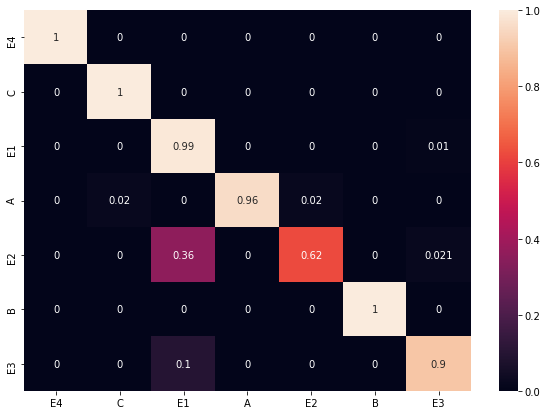

In [10]:
# Print confusion matrix on training data
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
data = [line.strip().replace("[","").replace("]","").split(",") for line in open("confusion.csv")]
labels = data[0][1:]
data = [[float(v) for v in line[1:-1]] for line in data[1:]]
df = pd.DataFrame(data, index = [i for i in labels], columns = [i for i in labels])
df_norm_col = df.div(df.sum(axis=1), axis=0)
plt.figure(figsize = (10,7))
_ = sn.heatmap(df_norm_col, annot=True)

In [11]:
# Run evaluation with best validation model on validation
val = [line.strip().split() for line in open(DATA_DIR + prefix + ".val",'r')]
t_strs = np.array([sequence for label, sequence in val])
t_inps = [to_int(sequence) for label, sequence in val]
t_outs = np.array([lbls[label] for label, sequence in val])
args.confusion = True
args.pconfusion = False
loss, acc = net.run_evaluation(t_inps, t_outs, showTrain=False, verbose=True)
print("Acc: {:5.3f}".format(acc))

100%|██████████████████████████████████████████| 32/32 [00:00<00:00, 301.58it/s]

E1         51    0.785 1.000 0.879   
E2         29    1.000 0.621 0.766   
C          24    1.000 1.000 1.000   
A          9     1.000 1.000 1.000   
E3         5     1.000 0.400 0.571   
B          4     1.000 1.000 1.000   
E4         4     1.000 1.000 1.000   
Acc: 88.889


In [12]:
# Run evaluation with best validation model on test
val = [line.strip().split() for line in open(DATA_DIR + prefix + ".test",'r')]
t_strs = np.array([sequence for label, sequence in val])
t_inps = [to_int(sequence) for label, sequence in val]
t_outs = np.array([lbls[label] for label, sequence in val])
loss, acc = net.run_evaluation(t_inps, t_outs, showTrain=False, verbose=True)
print("Acc: {:5.3f}".format(acc))

100%|██████████████████████████████████████████| 69/69 [00:00<00:00, 352.47it/s]

E1         117   0.865 0.983 0.920   
C          61    1.000 1.000 1.000   
E2         52    0.972 0.673 0.795   
A          15    0.938 1.000 0.968   
E3         11    0.700 0.636 0.667   
E4         9     0.889 0.889 0.889   
B          8     1.000 1.000 1.000   
Acc: 91.209
